<a href="https://colab.research.google.com/github/donghui-0126/machine-learning/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2%EC%9E%A5%20%EB%94%A5%EB%9F%AC%EB%8B%9D/%5B16%EC%9E%A5%5D_RNN%EA%B3%BC_%EC%96%B4%ED%85%90%EC%85%98%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%9E%90%EC%97%B0%EC%96%B4_%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- conding:utf-8 -*-

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

이번 장에서는 자연어를 읽고 쓰는 AI를 만드는 법을 알아볼 것이다. 

자연어 문제를 위해 많이 사용하는 방법은 순환 신경망이다. 따라서 RNN을 계속해서 살펴본다. 문장에서 다음글자를 예측하도록 훈련하는 **문자 단위 RNN(character RNN)** 부터 시작한다. 새로운 텍스트를 생성하고 그 과정에서 매우 긴 시퀀스를 가진 텐서플로 데이터셋을 만드는 방법을 알아보자. 먼저 **상태가 없는 RNN(stateless RNN)** 을 사용하고 다음에 **상태가 있는 RNN(stateful RNN)** 을 구축할 것이다. (상태가 없는 RNN은 각 반복에서 무작위하게 택한 텍스트의 일부분으로 학습하고, 나머지 텍스트에서 어떤 정보도 사용하지 않는다. 상태가 있는 RNN은 훈련 반복 사이에 은닉 상태를 유지하고 중지된 곳에서 이어서 상태를 반영한다. 그래서 더 긴패턴을 학습할 수 있다). 그 다음에는 감성분석을 수행하는 RNN을 구축하고 이번에는 문자가 아니라 단어의 시퀀스로 문장을 다룰것이다. 그리고 신경망 기계번역(NMT)을 수행할 수 있는 인코더-디코더 구조를 만들기 위해 RNN을 사용하는 방법을 알아보자. 도구로는 텐서플로 애드온 프로젝트에서 제공하는 seq2seq API를 사용한다.

16.4절에서는 어텐션 매커니즘을 알아보자. 이름에서 알 수 있듯이 이는 각 타임 스텝에서 모델이 집중해야 할 입력 부분을 선택하도록 학습하는 신경망 구성요소이다. 먼저 어텐션을 사용하여 RNN 기반의 인코더-디코더 구조의 성능을 높이는 방법을 알아본 뒤, RNN을 모두 제거하고 어텐션만 사용해 매우좋은 성능을 내는 **트랜스포머** 라는 구조도 살펴보자.  마지막으로 NLP분야에서 가장 중요한 발전을 살펴보자. 트랜스포머를 시반으로 한 GPT-2와 BERT같은 매우 강력한 언어 모델도 포함한다.

# char-RNN을 사용해 셰익스피어 문체 생성하기

In [ ]:
shakespeare_url = "https://homl.info/shakespeare"  # 단죽 url
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
# 모든 글자를 정수로 인코딩해준다. 
# 간단하게 Tokenizer 클래스를 사용한다.

# char_level 을 True로 지정해서 단어 수준 인코딩 대신 글자 수준 인코딩을 만든다. 이 클래스는 기본적으로 텍스트를 소문자로 바꾼다.
# 이제 문장을 글자 ID로 인코딩 하거나 반대로 디코딩 할 수 있다. 
# 이를 통해텍스트에 있는 고유 글자 개수와 전체 글자 개수를 알 수 있다.
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20,6,9,8,3]])

['f i r s t']

In [ ]:
# 고유 글자 개수
max_id = len(tokenizer.word_index)
max_id

39

In [ ]:
# 전체 글자 개수
dataset_size = tokenizer.document_count 
dataset_size

1115394

In [ ]:
# 전체 텍스트를 인코딩해서 각 글자를 ID로 나타내 보자.
# 1~ 39인 값을 0~38로 바꾸기
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [ ]:
encoded.shape

(1115394,)

## 순차 데이터셋을 나누는 방법
훈련셋, 테스트셋, 검증셋을 중복되지 않도록 만드는 것은 중요하다.

보통 시계열을 다룰 때는 시간에 따라 나눈다. 다른 차원으로 나눌 수 있지만, train set 과 test set 사이의 상관관계가 있다면 오차를 낙관적으로 측정해서 모델이 유용하지 않을 것이다. 

시계열 데이터가 시간에 따라서 반복되는 **변하지 않는 상태** 라면 시계열을 안정적으로 분석할 수 있다. 하지만 그렇지 않은 시계열도 있을 것이다. 

시계열이 안정적인지 확인할 방법은 시간에 따라 검증 세트에 대한 모델의 오차를 그리는 것이다. 모델이 검증 세트 마지막 보다 첫 부분에서 성능이 더 좋다면 이 시계열이 충분히 안정되지 않을 것일 수 있다. 이런 경우에는 **더 짧은 사건 간격으로** 모델을 훈련하는 게 좋다.

In [ ]:
# 셰익스피어 텍스트의 처음 90%를 trainset으로 사용하고 나머지는 validset과 testset로 사용한다. 
# 이 set에서 한 번에 한 글자씩 반환하는 tf.data.Dataset 객체를 만든다.
train_size = dataset_size * 90 // 100
dataset1 = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
train_size

1003854

## 순차 데이터를 윈도 여러개로 자르기

https://teddylee777.github.io/tensorflow/dataset-batch-window  이해가 잘 안되서 찾아본 블로그이다. 

trainset은 백만개 이상의 글자로 이루어진 시퀀스 하나이다. 여기에 신경망을 직접 훈련시킬수는 없다. 이 RNN은 백만 개의 층이 있는 심층 신경망과 비슷하고 (매우 긴) 샘플 하나로 훈련하는 셈이 된다. 대신 데이터셋의 window() 메서드를 사용해 이 긴 시퀀스를 작은 많은 텍스트 윈도로 변환한다. 이 데이터셋의 각 샘플은 전체 텍스트에서 매우 짧은 부분 문자열이다. RNN은 이 부분문자열 길이만큼만 역전파를 위해 펼쳐진다. 이를 **TBPTT** 라고 한다. window() 메서드를 호출하여 짧은 텍스트 윈도를 갖는 데이터셋을 만들어보자.

In [ ]:
# n_steps를 튜닝할 수 있다.
# 짧은 입력 시퀀스에서 RNN을 훈련하는 것은 쉽지만 당연히 이 RNN은 n_steps 보다 긴 패턴을 학습할 수 없다.
n_steps = 100
window_length = n_steps + 1 # target = 한글자앞의 input
# window_depth: 윈도우 크기 
# shift: 원래는 윈도우크기가 default값이여서 윈도우가 겹치지 않음. shift=1 이면 최대크기의 trainset 생성
# drop_remainder: True로 지정하면 같은 크기의 윈도우를 생성함. False면 윈도우크기가 1씩 줄어든다. 
dataset1 = dataset1.window(window_length, shift=1, drop_remainder=True)

window()메서드를 사용하면 각각 하나의 데이터셋으로 표현되는 윈도를 포함하는 데이터셋을 만든다. 리스트의 리스트와 비슷한 nested dataset이다. 이런 구조는 데이터셋 메서드를 호출하여 각 윈도를 변환할 때 유용하다. 하지만 모델은 데이터셋이 아니라 tensor를 기대하기 때문에 훈련에 데이터셋을 바로 사용할 수 없다. 따라서 flat_map()을 통해서 nested dataset을 flat dataset으로 변환해주어야한다. 

flat_map()메서드는 중첩 dataset을 평평하게 만들기 전에 각 데이터셋에 적용할 변환 함수를 매개변수로 받을 수 있다. 예를 들어 lambda ds: ds.batch(2) 함수를 flat_map()에 전달하면 텐서 2개를 가진 테이터셋으로 변환해준다.

In [ ]:
# 윈도마다 batch(window_length)를 호출한다. 이 길이는 윈도 길이와 같기 때문에 텐서 하나를 담은 데이터 셋을 얻는다.
# 이 데이터셋은 연속된 101글자 길이의 윈도를 담는다.
dataset1 = dataset.flat_map(lambda window: window.batch(window_length))

TypeError: ignored

경사하강법은 훈련 세트 샘플이 동일 독립 분포 일 떄 가장 잘 작동하기 때문에 이 윈도를 섞어야한다. 그다음 윈도를 배치로 만들고 입력과 타깃으로 분리하겠다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

batch_size= 32
dataset1 = dataset1.shuffle(10000).batch(batch_size)
dataset1 = dataset1.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

TypeError: ignored

In [ ]:
# 범주형 입력특성이므로 원핫인코딩을 진행한다. (고유한 글자 수가 적기 때문에 임베딩 대신 원핫 인코딩을 사용함).
dataset1 = dataset1.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

마지막으로 프리페칭을 추가한다.

In [ ]:
dataset1 = dataset1.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


13장에 나온 데이터 전처리와 적재 파트의 공부를 건너 뛰어서 살짝 잘 모르겠는 부분이 있다. 이제 필요성을 느꼈으니 공부를 해야겠다.

## Char-RNN 모델 훈련

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# GRU 클래스는 다음 매개변수에서 기본값을 사용할 때에만 GPU를 사용합니다: 
# activation, recurrent_activation, recurrent_dropout, unroll, use_bias reset_after. 이 때문에 (책과는 달리) recurrent_dropout=0.2를 주석 처리했습니다.

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                   # dropout = 0.2, recurrent_dropout = 0.2),
                   dropout = 0.2),
    keras.layers.GRU(128, return_sequences=True,
                   # dropout = 0.2, recurrent_dropout = 0.2),
                   dropout = 0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])


# 손실함수는 https://didu-story.tistory.com/27 참조
# 라벨이 정수인코딩 된 경우에 사용함
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 420s 13ms/step - loss: 1.6238
Epoch 2/10
31368/31368 [==============================] - 392s 12ms/step - loss: 1.5397
Epoch 3/10
31368/31368 [==============================] - 396s 13ms/step - loss: 1.5191
Epoch 4/10
31368/31368 [==============================] - 389s 12ms/step - loss: 1.5076
Epoch 5/10
31368/31368 [==============================] - 393s 12ms/step - loss: 1.5000
Epoch 6/10
31368/31368 [==============================] - 411s 13ms/step - loss: 1.4943
Epoch 7/10
31368/31368 [==============================] - 397s 13ms/step - loss: 1.4906
Epoch 8/10
31368/31368 [==============================] - 394s 13ms/step - loss: 1.4876
Epoch 9/10
31368/31368 [==============================] - 390s 12ms/step - loss: 1.4854
Epoch 10/10
31368/31368 [==============================] - 397s 13ms/step - loss: 1.4828


In [ ]:
model.save("my_shakespeare_model.h5")

In [ ]:
model = keras.models.load_model("my_shakespeare_model.h5")

OSError: ignored

## Char-RNN 모델 사용하기.
이제 셰익스피어가 쓴 텍스트에서 다음 글자를 예측해주는 모델을 얻었다. 이 모델에 새로운 텍스트를 주입하려면 앞에서와 같이 먼저 전처리를 해야한다.

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

NameError: ignored

In [ ]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

## 가짜 셰익스피어 텍스트 생성하기 
Char-RNN 모델을 사용해 새로운 텍스트를 생성하려면 먼저 초기 텍스트를 주입하고 모델이 가장 가능성 있는 다음 글자를 예측한다. 이 글자는 텍스트 끝에 추가하고 늘어난 텍스트를 모델에 전달하여 다음 글자를 예측하는 방식이다. 실제로는 이렇게 하면 같은 단어가 계속 반복될 수 있다. 대신 tf.random.categorical()함수를 이용해 모델이 추정한 확률을 기반으로 다음 글자를 무작위로 선택할 수 있다.

categorical() 함수는 클래스의 로그 확률(로직)을 전달하면 랜덤하게 클래스 인덱스를 샘플링한다. 생성된 텍스트의 다양성을 더 많이제어하려면 temperature 라고 불리는 숫자로 로짓을 나눈다. 온도가 낮을수록 랜덤성이 줄고 온도가 높을 수록 랜덤성이 높아진다. 

In [ ]:
# 위 방식을 사용해서 다음 글자를 선택하고 그 텍스트를 반환한다.
def next_char(text, temperature=1):

    # X_new 형태와 y_proba 형태 살펴보기
    
    
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

NameError: ignored

In [ ]:
# 위 함수를 반복 호출하고 텍스트뒤에 합쳐주는 함수
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
print(complete_text("t", temperature=1))

NameError: ignored

## 상태가 있는 RNN

지금까지는 상태가 없는 RNN을 사용했다. 훈련 반복마다 모델의 은닉 상태를 0으로 초기화한다. 타임 스텝마다 이 상태를 업데이트하고 마지막 타임 스텝후에는 더 필요가 없기 때문에 버린다. RNN이 한 훈련 배치를 처리한 후에 마지막 상태를 다음 훈련 배치의 초기 상태로 사용하면 어떨까? 이렇게 하면 역전파는 짧은 시퀀스 안에서만 일어나지만 모델은 장기간 패턴을 학습 가능하다. 이를 **상태가 있는 RNN**이라고 한다.

먼저 상태가 있는 RNN은 배치에 있는 각 입력 시퀀스가 이전 배치의 시퀀스가 끝난 지점에서 시작해야한다. 따라서 상태가 있는 RNN을 만들기 위해 첫 번쨰로 할 일은 순차적이고 겹치지 않는 시퀀스를 만드는 것이다. (상태가 없는 RNN에서 사용된 겹치는 부분이 있는 Dataset이면 안된다). Dataset을 만들 때 window() 메서드에서 shift=n_steps로 지정해주면 된다. 또한 shuffle()메서드를 호출해서는 안된다. 안타깝게도 상태가 있는 RNN을 위한 데이터 셋은 상태가 없는 RNN의 경우보다 배치를 구성하기 더 힘들다. 실제로 batch(32)라고 호출하면 32개의 연속적인 윈도가 같은 배치에 들어간다. 이 윈도가 끝난 지점부터 다음배치가 계속되지 않는다. 첫 번째 배치는 1~32까지 포함하고 두번째 배치는 윈도 33부터 64까지 포함한다. 따라서 각 배치의 첫 번째 윈도를 생각하면 연속적이지 않음을 할 수 있다. 이 문제의 가장 간단한 해결책은 하나의 윈도를 갖는 배치를 만드는 것이다.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)
    print((X_batch[:][:][0]))

(1, 100, 39) (1, 100)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(100, 39), dtype=float32)


In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)
    print((X_batch[:][:][1]))

(32, 100, 39) (32, 100)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]], shape=(100, 39), dtype=float32)


In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                    dropout=0.2, batch_input_shape=[batch_size, None, max_id]),
                    # recurrent_dropout=0.2)
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                    dropout=0.2),
                     # recurrent_dropout=0.2)
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                   activation="softmax"))
])

In [ ]:
# 아무리 stateful RNN이라고 해도 에포크가 시작할 때는 state를 초기화해주어야한다.
# stateless RNN은 배치마다 state를 초기화하고, stateful RNN은 에포크마다 state를 초기화한다.

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 12s 15ms/step - loss: 2.6211
Epoch 2/50
313/313 [==============================] - 4s 14ms/step - loss: 2.2422
Epoch 3/50
313/313 [==============================] - 4s 14ms/step - loss: 2.1109
Epoch 4/50
313/313 [==============================] - 4s 14ms/step - loss: 2.0358
Epoch 5/50
313/313 [==============================] - 6s 21ms/step - loss: 1.9854
Epoch 6/50
313/313 [==============================] - 4s 14ms/step - loss: 1.9480
Epoch 7/50
313/313 [==============================] - 4s 14ms/step - loss: 1.9206
Epoch 8/50
313/313 [==============================] - 4s 14ms/step - loss: 1.8991
Epoch 9/50
313/313 [==============================] - 4s 14ms/step - loss: 1.8817
Epoch 10/50
313/313 [==============================] - 4s 14ms/step - loss: 1.8661
Epoch 11/50
313/313 [==============================] - 4s 14ms/step - loss: 1.8533
Epoch 12/50
313/313 [==============================] - 4s 14ms/step - loss: 1.8419
Epoch 13/50


In [ ]:
model.save("my_shakespeare_stateful_model.h5")

# 감성분석
이전까지는 글자 수준 모델을 만들었다. 이제 단어 수준 모델을 살펴보고 자주 등장하는 자연어 처리 작업인 감성분석을 다루어 보자. 이 과정에서 마스킹을 사용해 길이가 다른 시퀀스를 다루는 방법도 알아보자.

학습은 IMDb 리뷰 데이터 셋을 사용한다.

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()
X_train[0][:10]

17464789/17464789 [==============================] - 0s 0us/step


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

리뷰 내용은 어디 있을까? 사실 여기서 볼 수 있듯 이 데이터 셋은 이미 전처리되어있다. X_train은 리뷰들의 리스트이다. 각 리뷰는 넘파이 정수 배열로 표현된다. 각 정수는 하나의 단어를 나타낸다. 구두점을 모두 제거하고 단어는 소문자로 변환한 다음 공백으로 나누어 빈도에 따라 인덱스를 붙힌다. (따라서 정수가 낮을 수록 자주등장하는 단어이다). 정수 0, 1, 2는 특별하다. 각각 패딩토큰, SOS(start of sequence)토큰, 알 수 없는 단어를 의미한다. 리뷰 내용을 보고 싶다면 다음과 같이 디코딩할 수 있다.

In [4]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token

" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

실제 프로젝트에서는 스스로 텍스트 전처리를 진행해야한다. 그 때 이전에 사용했던 Tokenizer 클래스를 사용할 수 있다. 하지만 이번에는 char_level=False로 지정해서 단어 수준 모델을 만들 것이다. 단어를 인코딩할 때 필터는 " ", ".", "    " 등으로 단어를 구분할 수 있다. 영어는 이렇게 해도 괜찮지만, 다른 언어의 경우에 들어맞지 않는 경우가 있다. 

다행히도 더 좋은 옵션이 있다. 2018의 논문에서 언어에 의존하지 않는 방식으로 하위 단어 수준에서 텍스트를 토큰화하고 토큰을 해제하는 감독되지 않은 학습 기술을 도입하여 공간을 다른 문자와 같이 취급하는 방법이 소개 됐다.
<br>만약 새로운 단어가 입력되더라도 단어를 하위단어 수준으로 쪼개서 인식할 수 있는 방법이다.

다른 방법으로는 더 이전에 발표된 바이트 페어 인코딩(using byte pair encoding))을 사용하는 하위단어로 접근하는 방식과을 TF.Text 라이브러리로 사용하는 방법이 있다.

만약 내가 모델을 다른 전처리 함수를 사용하지 않고 모바일이나 웹브라우져에 배포한다고 생각해보자. 그럴 때는 오직 tensorflow operation만 사용해야 한다. 또한 모델에 전처리 함수가 속해있어야한다. 

일단, IMDb 리뷰를 로딩하자. 

In [6]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

 그 다음 전처리함수를 생성하자

In [11]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch


이 전처리 함수는 일단 리뷰를 잘라낸다. 오직 첫 300글자만을 남긴다. 이것은 학습속도를 늘리지만 모델의 성능에 큰영향을 미치지 않는다. 왜냐하면 보통 시작 두문장에서 영화에 대한 긍정과 부정을 알 수 있기 때문이다.

그 다음 \<br \\> 태그를 공백으로 바꾸어준다. 

그 다음 공백을 기준으로 리뷰를 나누어 준다. 그 다음 이 ragged tensro를 dense tensor로 바꾸어준다. 마지막으로 padding token "\<pad>"를 사용해서 모두 같은 길이로 패딩해준다.

그 다음 우리는 vocabulary를 구성해야한다. 이것은 모든 trainset을 한번 훑어보고, 전처리 함수를 적용하고, 각 단어들의 occurences를 알아보기 위해 Counter()를 사용해야한다.

In [12]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [13]:
# 가장 많이 나온 단어를 봐보자
vocabulary.most_common()[:3]

[(b'<pad>', 214462), (b'the', 61137), (b'a', 38564)]


우리가 모델을 볼때 모든 단어를 알아야하는 것은 아니다. 그렇기 때문에 10000개의 단어만 살펴보자

In [14]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

이제 단어들을 ID로 인코딩해주어야한다. 나는 100 out-of-vocabulary(oov)를 사용해서 lookup table를 만들겠다. (13장에 나온다)

In [18]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [19]:
table.lookup(tf.constant([b"Thus movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 7585,    12,    11, 10053]])>

Thus, movie, was는 각각 ID가 10000보다 작아서 table에서 발견할 수 있지만, faaaaaaaantastic은 찾을 수 없다. 그렇기 때문에 마지막 단어를 10000보다 크거나 같은 ID로 매핑해주겠다.

이제 최종 trainset을 만들 준비가 됐다. preprocess()를 통해 리뷰를 단어로 이루어진 시퀀스로 만들고 encode_words()를 사용해서 단어를 간다하게 인코딩할 것이다.

In [20]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [23]:
embed_size = 128
model = keras.models.Sequential([
    # 임베딩층을 사용했다/
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")                           
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 17s 11ms/step - loss: 0.6904 - accuracy: 0.5287
Epoch 2/5
782/782 [==============================] - 8s 11ms/step - loss: 0.5002 - accuracy: 0.7468
Epoch 3/5
782/782 [==============================] - 8s 11ms/step - loss: 0.3320 - accuracy: 0.8592
Epoch 4/5
782/782 [==============================] - 8s 11ms/step - loss: 0.2409 - accuracy: 0.9078
Epoch 5/5
782/782 [==============================] - 8s 11ms/step - loss: 0.1699 - accuracy: 0.9414


# 마스킹
방금 본 train_set에서 padding token을 무시할 수 없을까? 이건 간단하게 할 수 있따. 그냥 임베딩층에 mask_zero=True를 지정해주면 된다. 이러면 패딩토큰의 ID가 0이 되고 뒤에서는 padding token이 무시되게 된다.

(이 다음에 마스킹이 층마다 이루어지는 방식에 대해서 설명되어있는데, 이는 다음으로 넘기겠다.)


# 사전 훈련된 임베딩 재사용하기
텐서플로 허브 프로젝트는 사전훈련된 모델의 구성요소를 쉽게 재사용할 수 있게 만들었다. 모델의 요소는 modules이라 불린다. 간단하게 TF Hub repository를 보면 원하는 모델의 코드를 그냥 복사헤서 내 프로젝트에 포함시키면 된다. 

예를 들어, nnlm-en-dim50 문장 임베딩 모듈을 봐보자. 

In [24]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

hub.KerasLAyer은 해당 url에서 모듈을 다운 받는다.

원래는 모듈을 학습시킬 수 없지만, trainable=True을 지정하면 학습시킬 수 있다.

이제 hub모델로 학습을 진행해보자

In [25]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5466 - accuracy: 0.7253
Epoch 2/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5139 - accuracy: 0.7478
Epoch 3/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5086 - accuracy: 0.7514
Epoch 4/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5052 - accuracy: 0.7538
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5021 - accuracy: 0.7561


# NMT 인코더 - 디코더 네트워크
영어를 프랑스어로 바꾸는 번역기를 생각해보자.

 영어 문장은 인코더에 입력되고 디코더는 프랑스어 번역을 출력한다. 프랑스어 번역은 디코더의 입력으로도 사용되지만 한 단계 뒤로 이동한다. 다시 말해, 디코더는 이전 단계에서 출력해야 하는 단어를 입력으로 제공한다. 첫 번째 단어의 경우, SOS 토큰이 주어진다. 디코더는 EOS 토큰으로 문장을 끝낼 것으로 예상된다.

 영어 문장은 입력될때 거꾸로 입력된다. 이것은 영어단어의 시작이 인코더의 마지막 출력으로 나오게 한다. 이것은 번역하는데 도움이 되는 기술이다. 

 일단, 각 단어는 ID로 표현된다. 그 다음 임베딩 층이 단어 임베딩을 리턴한다. 단어 임베딍은 인코더와 디코더에 입력된다.
 

 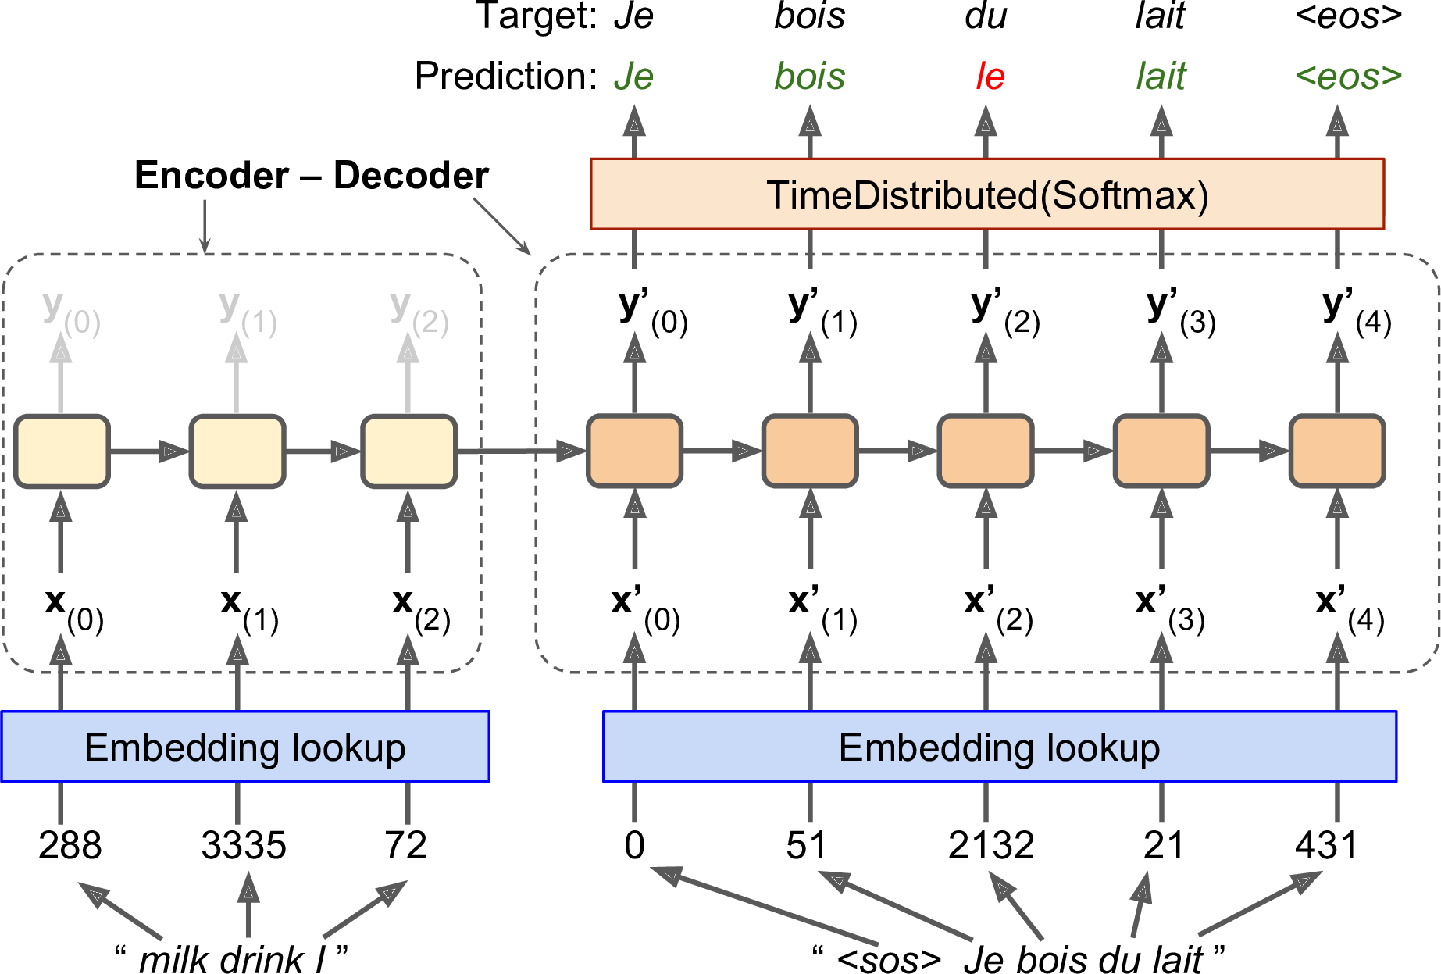

각 단계에서 디코더는 output vocabulary(즉, 프랑스어)의 각 단어에 대한 점수를 출력하고, 소프트맥스 층은 이러한 점수를 확률로 변환한다.

예를 들어, 첫스텝에서 "Je"는 20%의 확률을, "Tu"는 1%의 확률을 가진다. 가장 높은 확률을 가지는 단어가 output이다. 

이건 분류작업과 매우 비슷해서 손실함수로 "sparse_categorical_crossentropy로 사용할 수 있다. 

학습이 끄나면 내가 굳이 디코더에 입력을 해주지 않아도 된다. 대신에 그냥 이전 스텝에서의 아웃풋을 넣어주면 된다. 

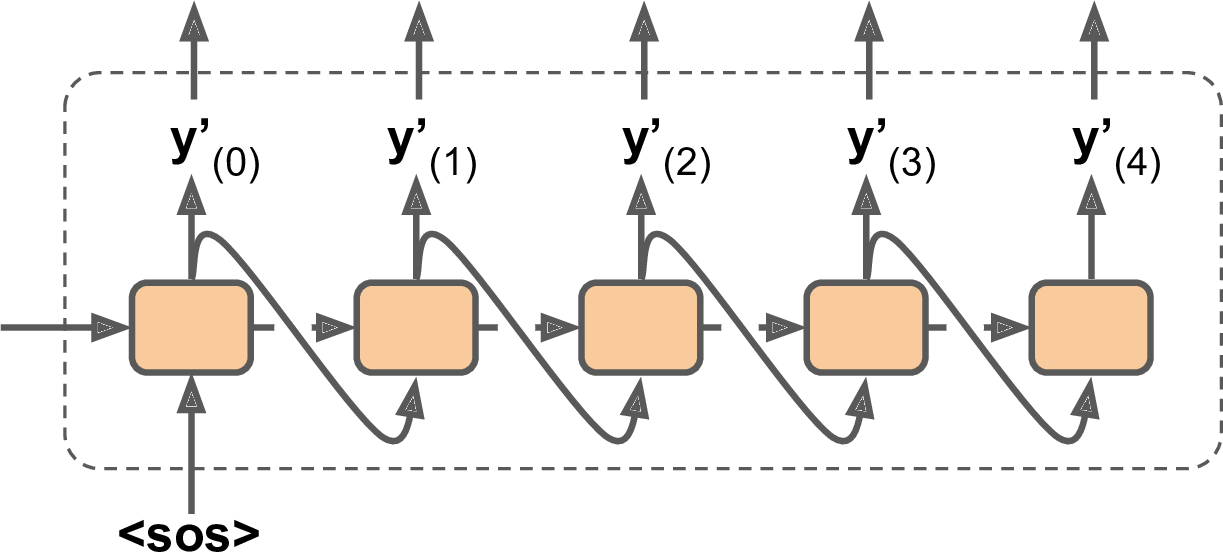

이제 대충 큰그림을 알게되었다. 그래도 모델을 위한 디테일이 몇가지 있다. 이를 알아보자